# PIV with two pass of WiDIM refinement
- using code SPIVET-UCLA, available at https://github.com/xiyuanbao/SPIVET-UCLA

In [71]:
from spivet.pivlib import *
from spivet import pivlib

In [72]:
from matplotlib import rcParams
import matplotlib.pyplot as plt

In [73]:
from scipy.interpolate import RectBivariateSpline

In [74]:
rcParams['figure.dpi'] = 300

In [75]:
import cv2
def shadow_filter(ofDisp):
    
    
    
    Vx = ofDisp[2,0,:,:]
    Vy = ofDisp[1,0,:,:]
    ofDisp[2,0,:,:] = shadow_filter_internal(Vx)
    ofDisp[1,0,:,:] = shadow_filter_internal(Vy)
    return ofDisp
#################################################################
def shadow_filter_internal(Vx):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))
    passes=0
    opt=(None,20,7,21)
    opt2=(None,10,7,21)
    mask_threshold=0.3
    core_correction = 0.2
    back_amp_correction = 1.1
    
    
    #median + non-local means
    Vx_f = median_NL_filter(Vx,passes,opt)
    
    mask = Vx-Vx_f
    mask[np.abs(mask)>mask_threshold]=1
    mask[np.abs(mask)<=mask_threshold]=0
    #morphological opening to remove lines and waves = plume shadows
    #but preserve plume cores
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    
    Vx_f[mask>0]=Vx[mask>0]+(Vx[mask>0]-Vx_f[mask>0])*core_correction
    Vx_f = median_NL_filter(Vx_f,0,opt2)
    Vx_f[mask<=0]*=back_amp_correction
    
    return Vx_f
#################################################################
def median_NL_filter(img,passes,opt):
    crc=img
    for i in range(passes):
        crc=cv2.medianBlur(np.float32(crc),3)
        crc=cv2.medianBlur(np.float32(crc),5)
    mind,maxd=np.min(crc),np.max(crc)
    crc8=np.uint8((crc-mind)/(maxd-mind)*255)


    medianflow_new = cv2.fastNlMeansDenoising(crc8,*opt)#cv2.fastNlMeansDenoising(crc8,5,5,3,7)
    medianflow_new = (medianflow_new/255.0)*(maxd-mind)+mind
    return medianflow_new

In [76]:
import numpy as np

In [77]:
base = "/home/xbao/LAB_test/shadow_piv_sim/photon/sample-data/piv/images/tif/particle_image_frame_000"
suffix = "_clean.tif"
files = [base+"1"+suffix,base+"2"+suffix]


f1_ = imread(files[0])[-1]
f2_ = imread(files[1])[-1]

imdim = f1_.shape

pad_pix = 32
f1 = np.zeros([imdim[0]+pad_pix*2,imdim[1]+pad_pix*2])
f1[pad_pix:-pad_pix,pad_pix:-pad_pix] = f1_
f2 = np.zeros([imdim[0]+pad_pix*2,imdim[1]+pad_pix*2])
f2[pad_pix:-pad_pix,pad_pix:-pad_pix] = f2_

#overlapping window used, add 16 pixels to have 64x64 vectors
pivdict = {
    'gp_rbndx':np.array([[pad_pix,imdim[0]+pad_pix*1.5],[pad_pix,imdim[1]+pad_pix*1.5]]),
    'gp_bsize':(32,32),
    'gp_bolap':(16,16),
    'gp_bsdiv':1,
    
    
    'ir_eps':0.003,
    'ir_maxits':100,
    'ir_mineig':0.05,
    'ir_imthd':'C',
    'ir_iedge':0,
    'ir_tps_csrp':0.1,
    'ir_tps_ithp':90,
    'ir_tps_wsize':[5,5],
    'ir_tps_sdmyf':0.1,
    'ir_tps_alpha':0.8,
    'ir_tps_beta':1.5,
    'ir_tps_csize':15,
    'ir_tps_nits':30,
    'ir_tps_scit':5,
    'ir_tps_annl':0.98,
    
    'of_maxdisp':(15,5),
    'of_rmaxdisp':(3,3),
    'of_hrsc':False,
    'of_nccth':0.7,
    'of_highp':False,
    'of_bsdcmx':0.,
}

STARTING: imread
 | Path: /home/xbao/LAB_test/shadow_piv_sim/photon/sample-data/piv/images/tif/particle_image_frame_0001_clean.tif
 | Mode: L
 | Size: (1024, 1024)
 | EXITING: imread
STARTING: imread
 | Path: /home/xbao/LAB_test/shadow_piv_sim/photon/sample-data/piv/images/tif/particle_image_frame_0002_clean.tif
 | Mode: L
 | Size: (1024, 1024)
 | EXITING: imread


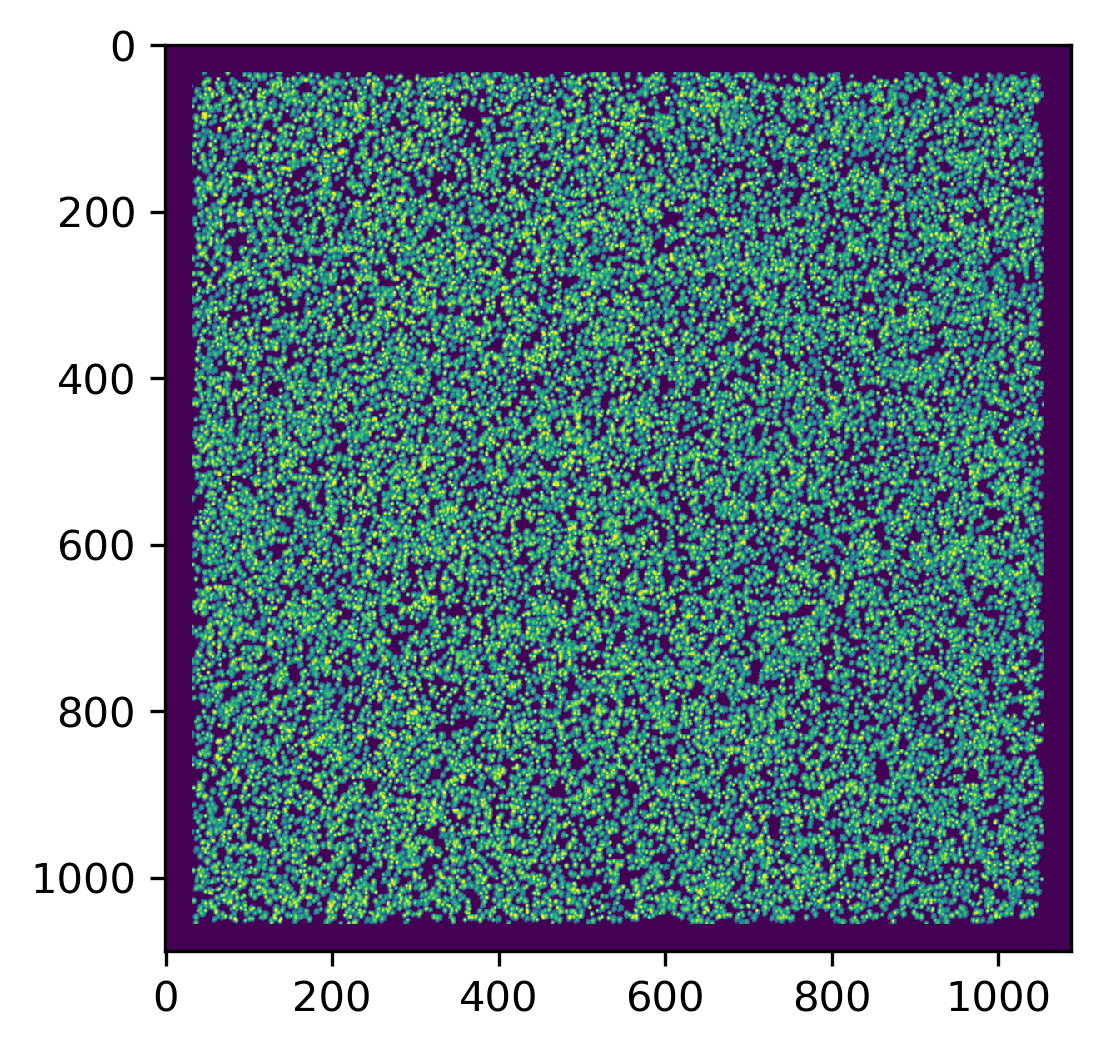

In [78]:
plt.imshow(f1)

In [79]:
rslt = ofcomp(f1,f2,pivdict)

STARTING: ofcomp
 | WARNING: Region not spanned by an integer number of blocks in y.
 | WARNING: Region not spanned by an integer number of blocks in x.
rsize,lbso,hbso,lnblks,hnblks= [1040. 1040.] [16 16] [32 32] [64 64] [64 64]
rbndx,bsize,bolap,bsdiv,bsdcmx= [[  32. 1072.]
 [  32. 1072.]] (32, 32) (16, 16) 1 0.0
 | nyblks 64
 | nxblks 64
 | Flow computation ...
 |  10% complete
 |  20% complete
 |  30% complete
 |  40% complete
 |  50% complete
 |  60% complete
 |  70% complete
 |  80% complete
 |  90% complete
 |  100% complete
 | NCC CMAX MEAN: 0.968415, STDDEV 0.030666
 | EXITING: ofcomp


In [80]:
import cv2
def median_gaussian(ofDisp,blurry=True):
    ofDisp_ = ofDisp.copy()
    for i in [1,2]:
        blur=cv2.medianBlur(np.float32(ofDisp[i,0,:,:]),3)
        blur=cv2.medianBlur(blur,5)
        if blurry:
            blur = cv2.GaussianBlur(blur,(3,3),0)
        ofDisp_[i,0] = blur
    return ofDisp_

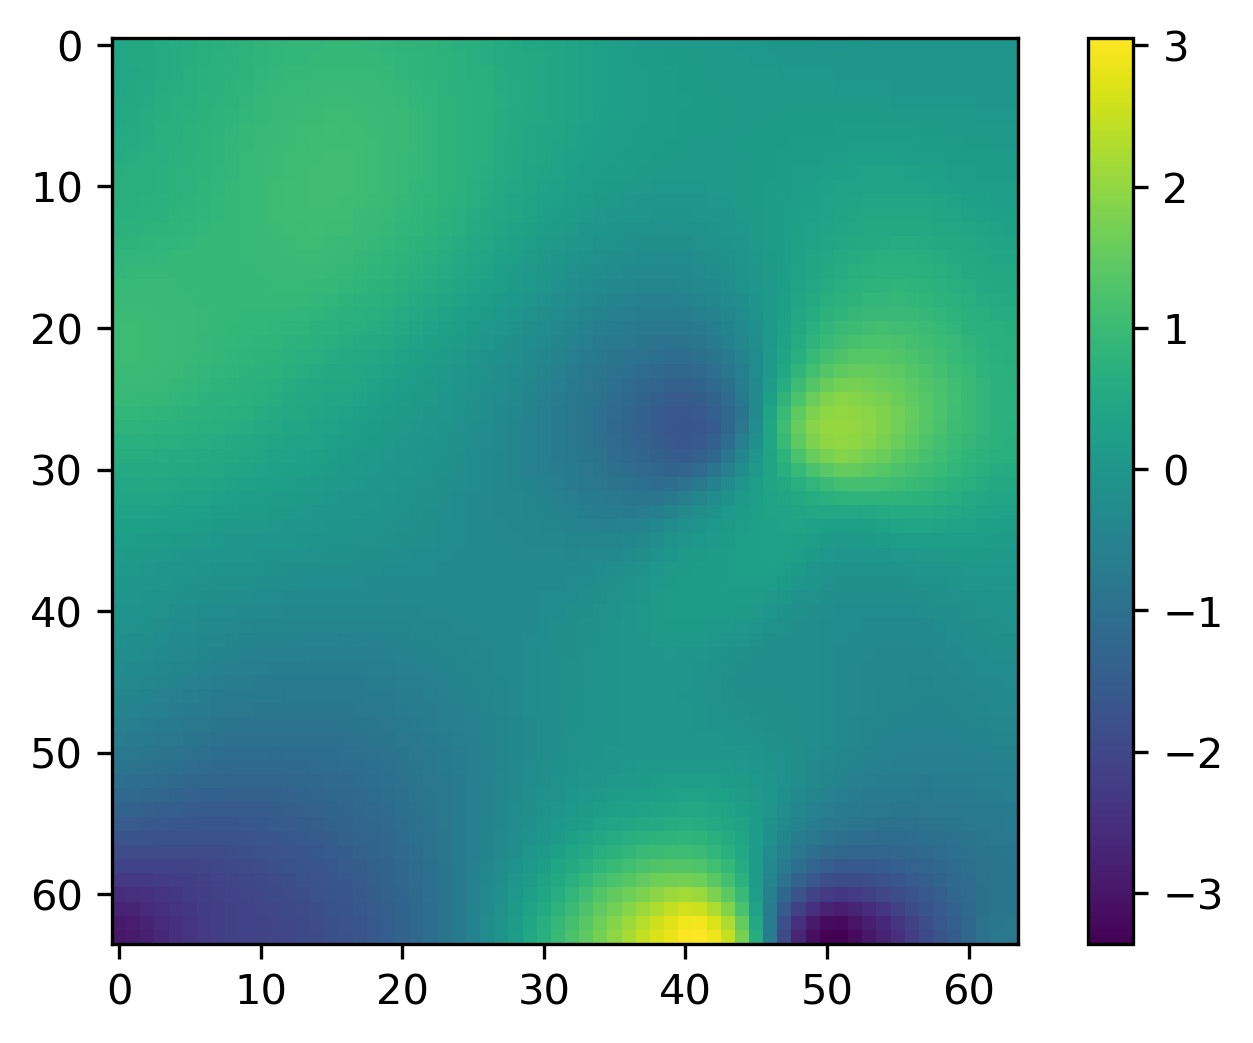

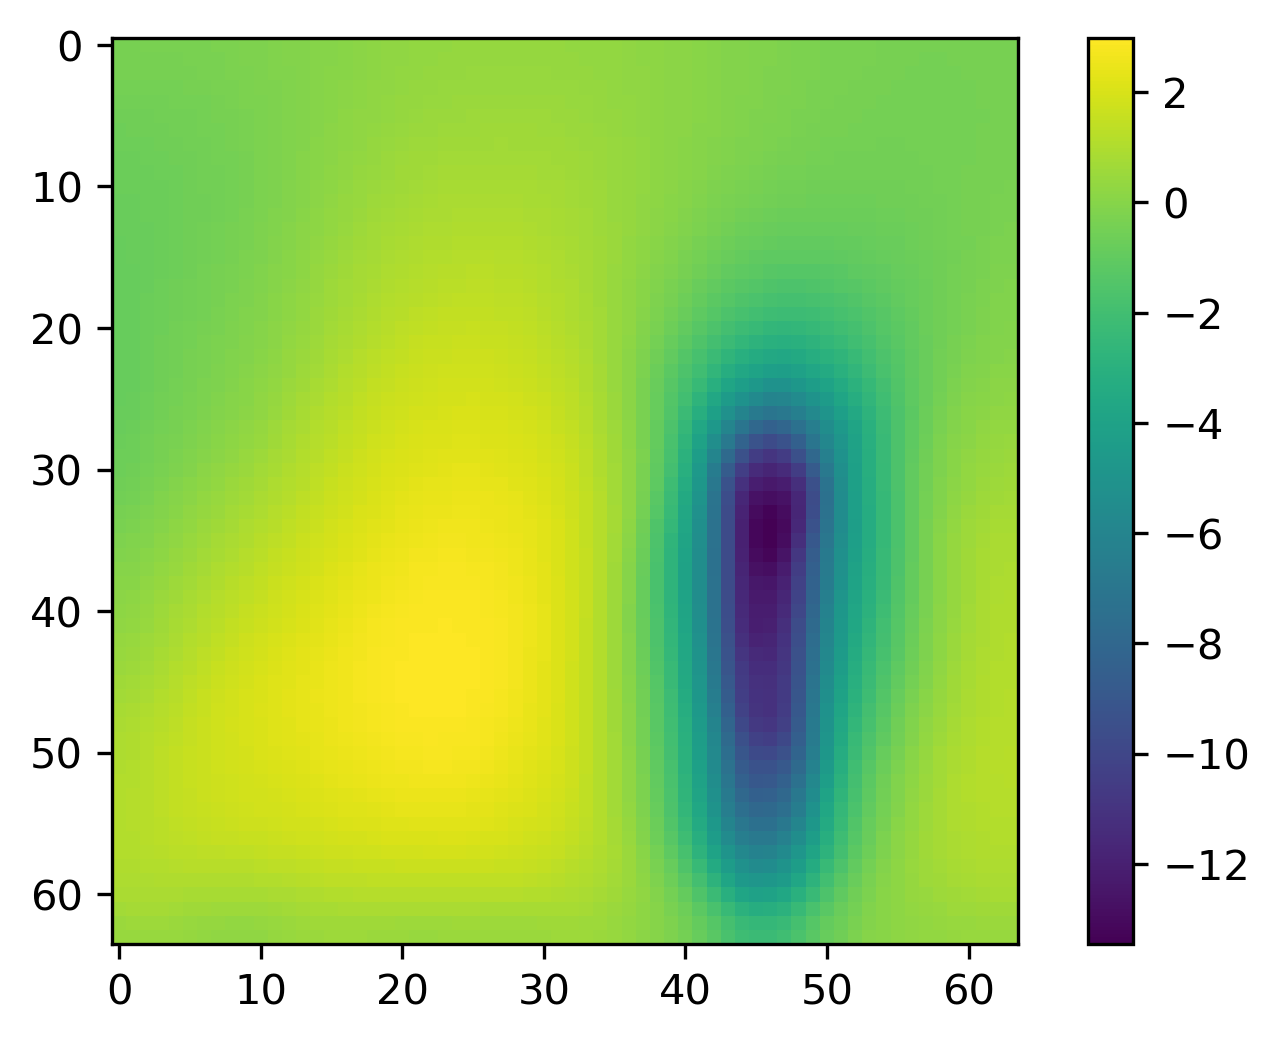

In [81]:
ofDisp,ofINAC,ofCMAX = rslt

ofDisp = median_gaussian(ofDisp)
plt.imshow(ofDisp[2,0,:,:])
plt.colorbar()
plt.figure()
plt.imshow(ofDisp[1,0,:,:])
plt.colorbar()

## refinement pass 1

In [84]:
def __regionprms__(pivdict,crbndx,pxorgn):
    """
    Computes region bounding indices and block center coords.
    """
    crsize   = crbndx[:,1] -crbndx[:,0]
    tnrcells = crsize.prod()

    # Get pivdict parameters.
    rbndx = array( pivdict['gp_rbndx'] ,dtype=int)
    bsize = array( pivdict['gp_bsize'] ,dtype=int)
    bolap = array( pivdict['gp_bolap'] ,dtype=int)
    bsdiv = pivdict['gp_bsdiv']

    maxdisp  = array( pivdict['of_maxdisp'] )
    rmaxdisp = array( pivdict['of_rmaxdisp'] )

    # Compute image region rbndx corresponding to crbndx.
    rrbndx = rbndx.copy()
    ebsize = (bsize -bolap)/bsdiv#bsdiv will not be used together with bsize>1 in ofcomp
    '''
    rrbndx[:,0] = rbndx[:,0] +crbndx[:,0]*ebsize -pxorgn
    rrbndx[:,1] = rbndx[:,0] +crbndx[:,1]*ebsize -pxorgn
    '''
    #Xiyuan:For overlapped cases, if keep crsize & tnrcells, we need to
    #compensate for the initial position 
    rrbndx[:,0] = rbndx[:,0] +crbndx[:,0]*ebsize -pxorgn 
    rrbndx[:,1] = rbndx[:,0] +crbndx[:,1]*ebsize -pxorgn +bolap

    # Compute extended rrbndx.  The extended region contains a border of
    # of_maxdisp +of_rmaxdisp pixels.  
    mxdsp   = maxdisp +rmaxdisp
    xrrbndx = rrbndx.copy()
    print xrrbndx
    xrrbndx[:,0] = xrrbndx[:,0] -mxdsp
    xrrbndx[:,1] = xrrbndx[:,1] +mxdsp

    xrrsize = np.array(xrrbndx[:,1] -xrrbndx[:,0],dtype=int)

    # Setup image indices and block center coordinates (in pixels) for the
    # extended region.  Coordinates are relative to the extended region.

    xrrfn = indices(xrrsize,dtype=float)
    xrrfn = xrrfn.reshape([2,xrrfn[0].size]).transpose()
    xrrfn = xrrfn +xrrbndx[:,0]

    wxrrfn = zeros(xrrfn.shape,dtype=float)

    bco    = bsize/(2.*bsdiv)
    bccrds = indices(crsize,dtype=float)
    for i in xrange(2):
        bccrds[i,...] = ebsize[i]*bccrds[i,...] +rrbndx[i,0] +bco[i]

    bccrds  = bccrds.reshape([2,tnrcells]).transpose()

    # Build the dictionary.
    rprms = {'crsize':crsize,
             'tnrcells':tnrcells,
             'xrrbndx':xrrbndx,
             'xrrsize':xrrsize,
             'rrbndx':rrbndx,
             'xrrfn':xrrfn,
             'wxrrfn':wxrrfn,
             'bccrds':bccrds}

    return rprms

In [85]:
crbndx  = array([[0,ofDisp.shape[-2]],[0,ofDisp.shape[-1]]])

crsize   = crbndx[:,1] -crbndx[:,0]
tnrcells = crsize.prod()


# Get a reference to the original rbndx.  We'll need to restore this
# later.
orbndx = pivdict['gp_rbndx']

# Grab the pixel origin for the extended region in relation to
# the full image.
rprms   = __regionprms__(pivdict,crbndx,[0,0])
xrrbndx = rprms['xrrbndx']
pxorgn  = xrrbndx[:,0]

ocrbndx = crbndx

print "-v-v-v-v-v- REFINE2DOF -v-v-v-v-v-"
print "EXT REGION: [%i:%i,%i:%i] PIX" % tuple(xrrbndx.reshape(4))



# Get region parameters for cam 0.
pivdict['gp_rbndx'] = orbndx

crbndx = ocrbndx
rprms  = __regionprms__(pivdict,crbndx,pxorgn)

crsize   = rprms['crsize']
tnrcells = rprms['tnrcells']
xrrbndx  = rprms['xrrbndx']
xrrsize  = rprms['xrrsize']
rrbndx   = rprms['rrbndx']
xrrfn    = rprms['xrrfn']
wxrrfn   = rprms['wxrrfn']
bccrds   = rprms['bccrds']
            
            

[[  32 1072]
 [  32 1072]]
-v-v-v-v-v- REFINE2DOF -v-v-v-v-v-
EXT REGION: [14:1090,24:1080] PIX
[[  18 1058]
 [   8 1048]]


In [86]:
pf0_cam0 = f1.copy()
rfactor=1.2
var = ofDisp.copy()
dbccrds = bccrds +var[1:3,0,...].reshape([2,tnrcells]).transpose()



# initialize the principle warp matrix
tps     = pivlib.pivutil.tpswarp(dbccrds,bccrds,lmda=0.,forwardonly=True)

# Get warped coordinates (ie, coordinates to warp Frame 0).  
# Do the fast approximate TPS for large region
# TPS on a corasegrid (cstep) inside fine border grid (flen)
# Then interpolate to per pixel grid using bivariate spline
# cstep=20-> max error<0.045 (1 time) default value
# cstep=16-> max error<0.025 (1.4 time)
# cstep=10-> max error~0.01(2 time)

if var.shape[2]>50 and var.shape[3]>50:
    flen=10;cstep=20
elif var.shape[2]>25 and var.shape[3]>25:
    flen=5;cstep=5
elif var.shape[2]>10 and var.shape[3]>10:
    flen=2;cstep=2
else:
    flen=0;cstep=0

if flen>0 and cstep > 0:
    ydim,xdim = np.array(xrrfn[-1]-xrrfn[0]+1,dtype=int)
    ysub = np.concatenate((np.arange(0,flen),np.arange(flen,ydim-flen,cstep),
                         np.arange(ydim-flen,ydim)),axis=None)+xrrfn[0][0]
    xsub = np.concatenate((np.arange(0,flen),np.arange(flen,xdim-flen,cstep),
                         np.arange(xdim-flen,xdim)),axis=None)+xrrfn[0][1]

    x2d,y2d = np.meshgrid(xsub,ysub)
    xrrfn_sub = np.array([y2d.flatten(),x2d.flatten()]).transpose()
    wxrrfn_sub = tps.xfrm(xrrfn_sub)
    p_sub = xrrfn_sub -wxrrfn_sub

    ytps_sub = p_sub[:,0].reshape(y2d.shape)
    xtps_sub = p_sub[:,1].reshape(x2d.shape)
    interp_spliney = RectBivariateSpline(ysub, xsub, ytps_sub)
    interp_splinex = RectBivariateSpline(ysub, xsub, xtps_sub)
    yo = np.arange(ydim)+xrrfn[0][0]
    xo = np.arange(xdim)+xrrfn[0][1]
    ytps = interp_spliney(yo, xo)
    xtps = interp_splinex(yo, xo)

    p = np.array([ytps,xtps]).reshape(2,-1).transpose()
else:#original TPS
    wxrrfn = tps.xfrm(xrrfn)
    p = xrrfn -wxrrfn



wimg = pivlib.pivutil.pxshift(f1,xrrfn.astype(int),p)

wimg = wimg.reshape(xrrsize)


pf0_cam0[xrrbndx[0,0]:xrrbndx[0,1],
         xrrbndx[1,0]:xrrbndx[1,1]] = wimg




In [87]:
# Compute flow.
[crc,inac,cmax] = pivlib.ofcomp(pf0_cam0,
                                        f2,
                                        pivdict)
#Xiyuan
# if not gpu: 
#     [crc,inac,cmax] = pivlib.ofcomp(pf0[cam],
#                                         fimgs[cam][1],
#                                         pivdict)
# else:
#     try:
#         [crc,inac,cmax] = pivlib.ofcomp_gpu(pf0[cam],
#                                         fimgs[cam][1],
#                                         pivdict)
#     except:
#         print "OPENPIV Failed. Use ofcomp."
#         [crc,inac,cmax] = pivlib.ofcomp(pf0[cam],
#                                         fimgs[cam][1],
#                                         pivdict)
        
# Filter the correction and apply.
# crc = self.__cfilter__(crc, cfltrprm)
# median3,median5,optional guassian

# import cv2
# blur=cv2.medianBlur(np.float32(ofDisp[2,0,:,:]),3)
# blur=cv2.medianBlur(blur,5)
# blur = cv2.GaussianBlur(blur,(5,5),0)

# cmag = crc[1:3,...].reshape([2,tnrcells])
# cmag = sqrt( (cmag*cmag).sum(0) )
# cmmx = cmag.max()
# print "IT%i MAX |CRC|: %f" % (it,cmmx)
crc = median_gaussian(crc)
rfactor=1.2
var = var +rfactor*crc

             

STARTING: ofcomp
 | WARNING: Region not spanned by an integer number of blocks in y.
 | WARNING: Region not spanned by an integer number of blocks in x.
rsize,lbso,hbso,lnblks,hnblks= [1040. 1040.] [16 16] [32 32] [64 64] [64 64]
rbndx,bsize,bolap,bsdiv,bsdcmx= [[  32. 1072.]
 [  32. 1072.]] (32, 32) (16, 16) 1 0.0
 | nyblks 64
 | nxblks 64
 | Flow computation ...
 |  10% complete
 |  20% complete
 |  30% complete
 |  40% complete
 |  50% complete
 |  60% complete
 |  70% complete
 |  80% complete
 |  90% complete
 |  100% complete
 | NCC CMAX MEAN: 0.986784, STDDEV 0.017980
 | EXITING: ofcomp


## refinement pass 2

In [88]:
pf0_cam0 = f1.copy()
rfactor=1.2
# var = ofDisp.copy()
dbccrds = bccrds +var[1:3,0,...].reshape([2,tnrcells]).transpose()



# initialize the principle warp matrix
tps     = pivlib.pivutil.tpswarp(dbccrds,bccrds,lmda=0.,forwardonly=True)

# Get warped coordinates (ie, coordinates to warp Frame 0).  
# Do the fast approximate TPS for large region
# TPS on a corasegrid (cstep) inside fine border grid (flen)
# Then interpolate to per pixel grid using bivariate spline
# cstep=20-> max error<0.045 (1 time) default value
# cstep=16-> max error<0.025 (1.4 time)
# cstep=10-> max error~0.01(2 time)

if var.shape[2]>50 and var.shape[3]>50:
    flen=10;cstep=20
elif var.shape[2]>25 and var.shape[3]>25:
    flen=5;cstep=5
elif var.shape[2]>10 and var.shape[3]>10:
    flen=2;cstep=2
else:
    flen=0;cstep=0

if flen>0 and cstep > 0:
    ydim,xdim = np.array(xrrfn[-1]-xrrfn[0]+1,dtype=int)
    ysub = np.concatenate((np.arange(0,flen),np.arange(flen,ydim-flen,cstep),
                         np.arange(ydim-flen,ydim)),axis=None)+xrrfn[0][0]
    xsub = np.concatenate((np.arange(0,flen),np.arange(flen,xdim-flen,cstep),
                         np.arange(xdim-flen,xdim)),axis=None)+xrrfn[0][1]

    x2d,y2d = np.meshgrid(xsub,ysub)
    xrrfn_sub = np.array([y2d.flatten(),x2d.flatten()]).transpose()
    wxrrfn_sub = tps.xfrm(xrrfn_sub)
    p_sub = xrrfn_sub -wxrrfn_sub

    ytps_sub = p_sub[:,0].reshape(y2d.shape)
    xtps_sub = p_sub[:,1].reshape(x2d.shape)
    interp_spliney = RectBivariateSpline(ysub, xsub, ytps_sub)
    interp_splinex = RectBivariateSpline(ysub, xsub, xtps_sub)
    yo = np.arange(ydim)+xrrfn[0][0]
    xo = np.arange(xdim)+xrrfn[0][1]
    ytps = interp_spliney(yo, xo)
    xtps = interp_splinex(yo, xo)

    p = np.array([ytps,xtps]).reshape(2,-1).transpose()
else:#original TPS
    wxrrfn = tps.xfrm(xrrfn)
    p = xrrfn -wxrrfn



wimg = pivlib.pivutil.pxshift(f1,xrrfn.astype(int),p)

wimg = wimg.reshape(xrrsize)


pf0_cam0[xrrbndx[0,0]:xrrbndx[0,1],
         xrrbndx[1,0]:xrrbndx[1,1]] = wimg




In [89]:
# Compute flow.
[crc,inac,cmax] = pivlib.ofcomp(pf0_cam0,
                                        f2,
                                        pivdict)
#Xiyuan
# if not gpu: 
#     [crc,inac,cmax] = pivlib.ofcomp(pf0[cam],
#                                         fimgs[cam][1],
#                                         pivdict)
# else:
#     try:
#         [crc,inac,cmax] = pivlib.ofcomp_gpu(pf0[cam],
#                                         fimgs[cam][1],
#                                         pivdict)
#     except:
#         print "OPENPIV Failed. Use ofcomp."
#         [crc,inac,cmax] = pivlib.ofcomp(pf0[cam],
#                                         fimgs[cam][1],
#                                         pivdict)
        
# Filter the correction and apply.
# crc = self.__cfilter__(crc, cfltrprm)
# median3,median5,optional guassian

# import cv2
# blur=cv2.medianBlur(np.float32(ofDisp[2,0,:,:]),3)
# blur=cv2.medianBlur(blur,5)
# blur = cv2.GaussianBlur(blur,(5,5),0)

# cmag = crc[1:3,...].reshape([2,tnrcells])
# cmag = sqrt( (cmag*cmag).sum(0) )
# cmmx = cmag.max()
# print "IT%i MAX |CRC|: %f" % (it,cmmx)
# crc = median_gaussian(crc,blurry=False)
rfactor=1.2
# var = var +rfactor*crc

STARTING: ofcomp
 | WARNING: Region not spanned by an integer number of blocks in y.
 | WARNING: Region not spanned by an integer number of blocks in x.
rsize,lbso,hbso,lnblks,hnblks= [1040. 1040.] [16 16] [32 32] [64 64] [64 64]
rbndx,bsize,bolap,bsdiv,bsdcmx= [[  32. 1072.]
 [  32. 1072.]] (32, 32) (16, 16) 1 0.0
 | nyblks 64
 | nxblks 64
 | Flow computation ...
 |  10% complete
 |  20% complete
 |  30% complete
 |  40% complete
 |  50% complete
 |  60% complete
 |  70% complete
 |  80% complete
 |  90% complete
 |  100% complete
 | NCC CMAX MEAN: 0.991954, STDDEV 0.013539
 | EXITING: ofcomp


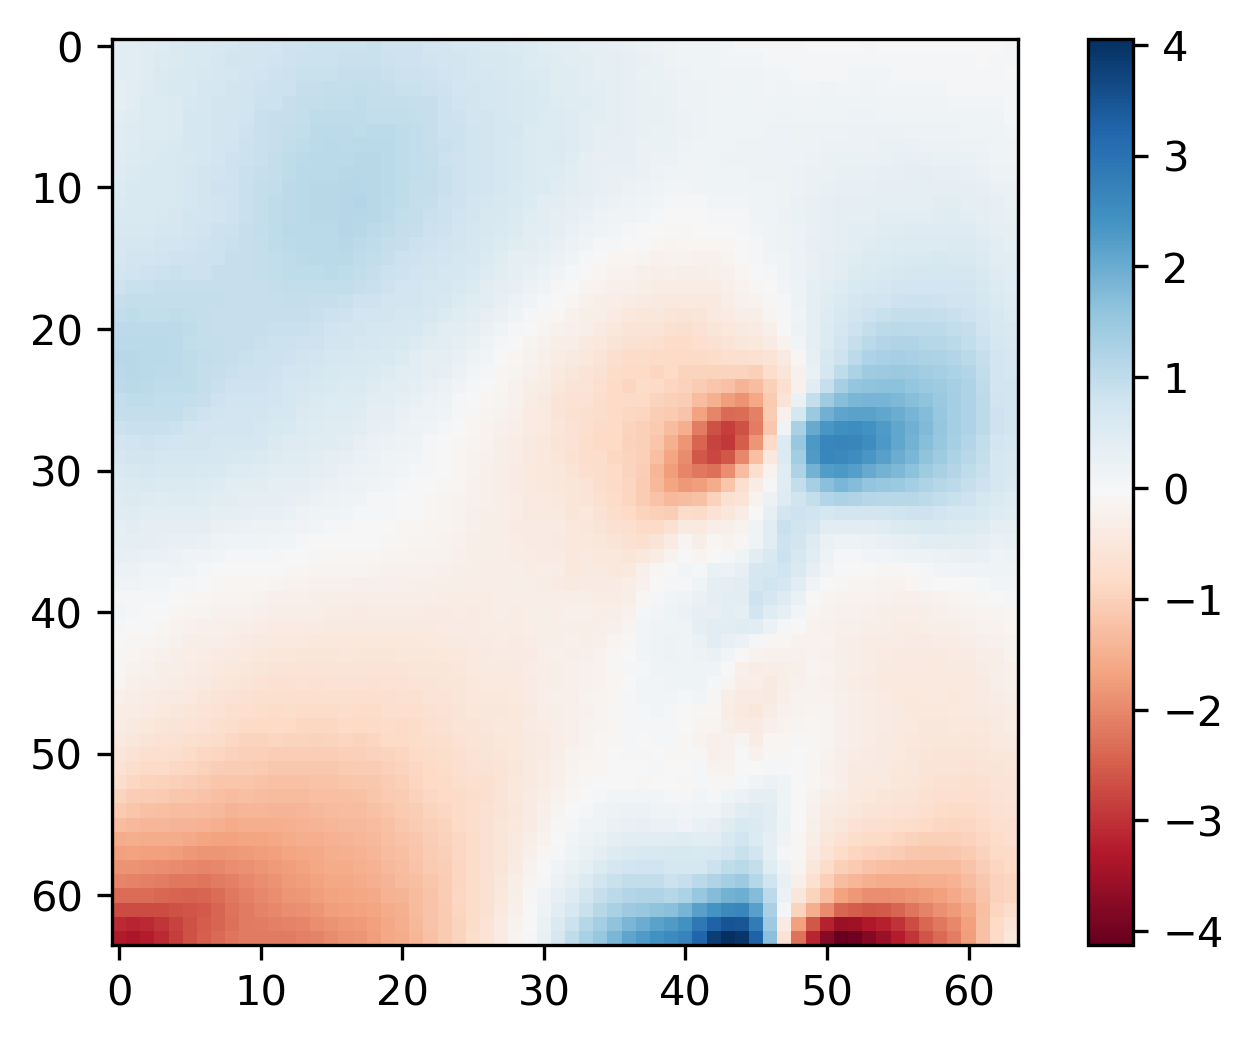

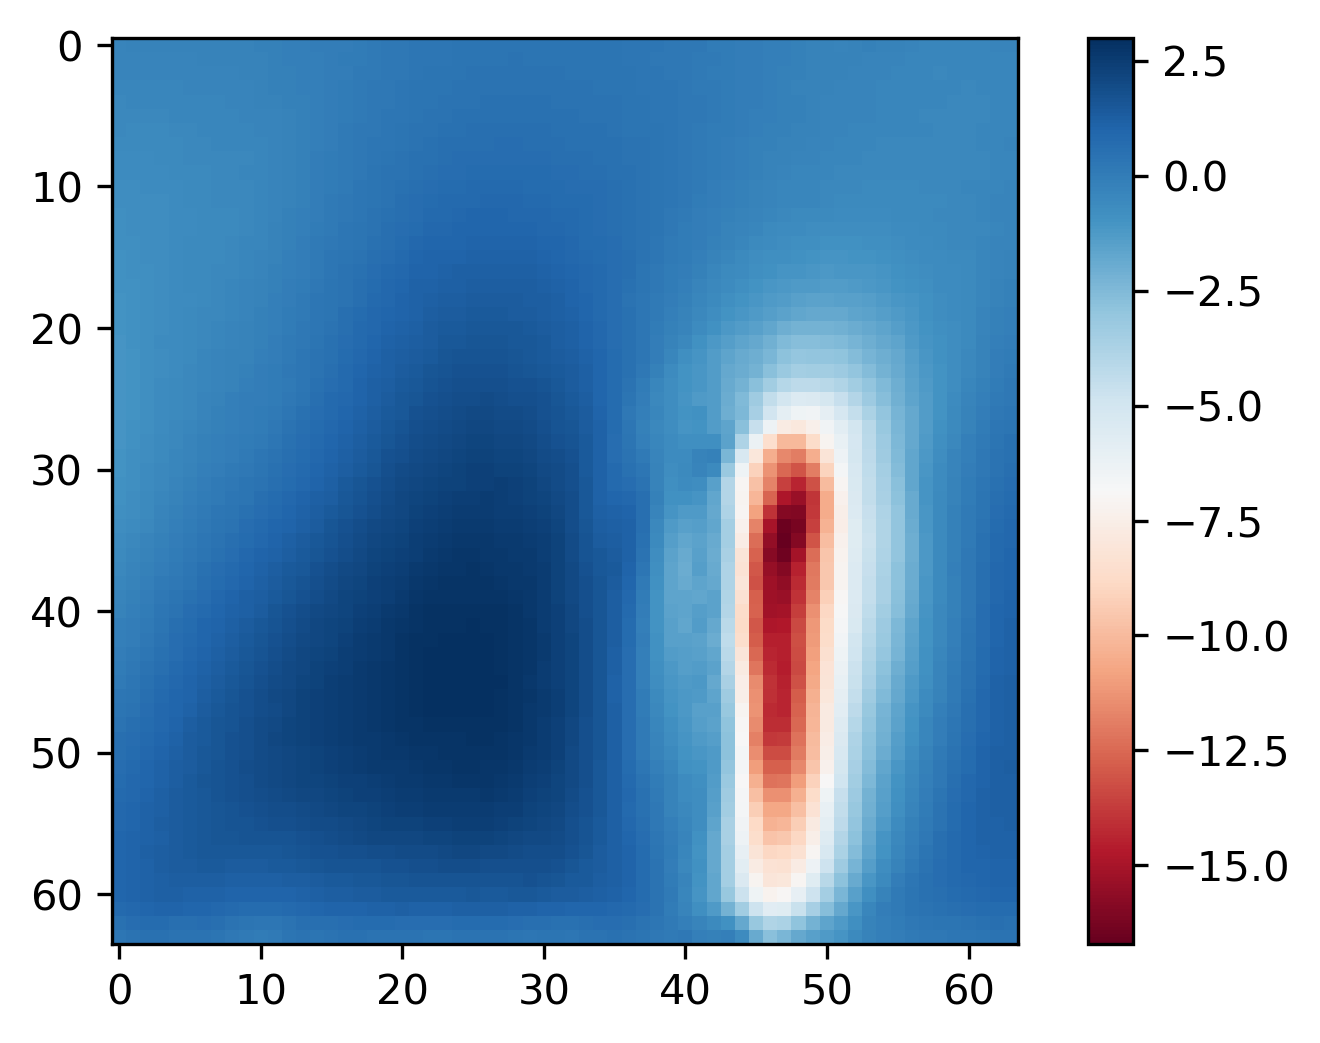

In [90]:
var_ = var +rfactor*crc

plt.imshow(var_[2,0,:,:],cmap="RdBu")
plt.colorbar()
plt.figure()
plt.imshow(var_[1,0,:,:],cmap="RdBu")
plt.colorbar()

In [91]:
var_ = var +median(rfactor*crc)#median 3 only

In [92]:
np.savez("synthetic_2d_ccpiv_noshadow.npz", u=var_[2,0,:,:], v=var_[1,0,:,:])

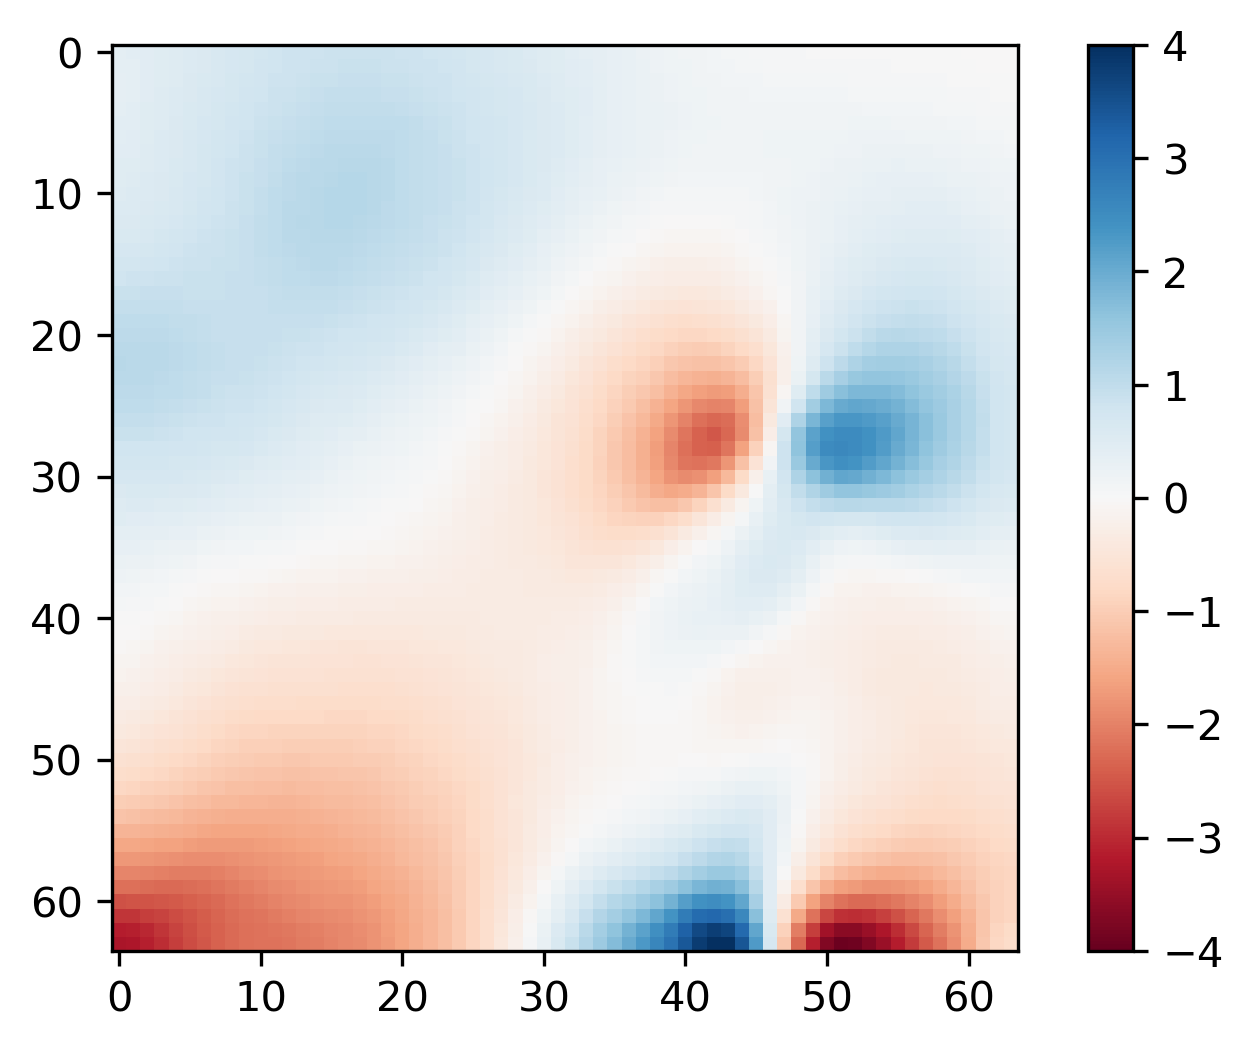

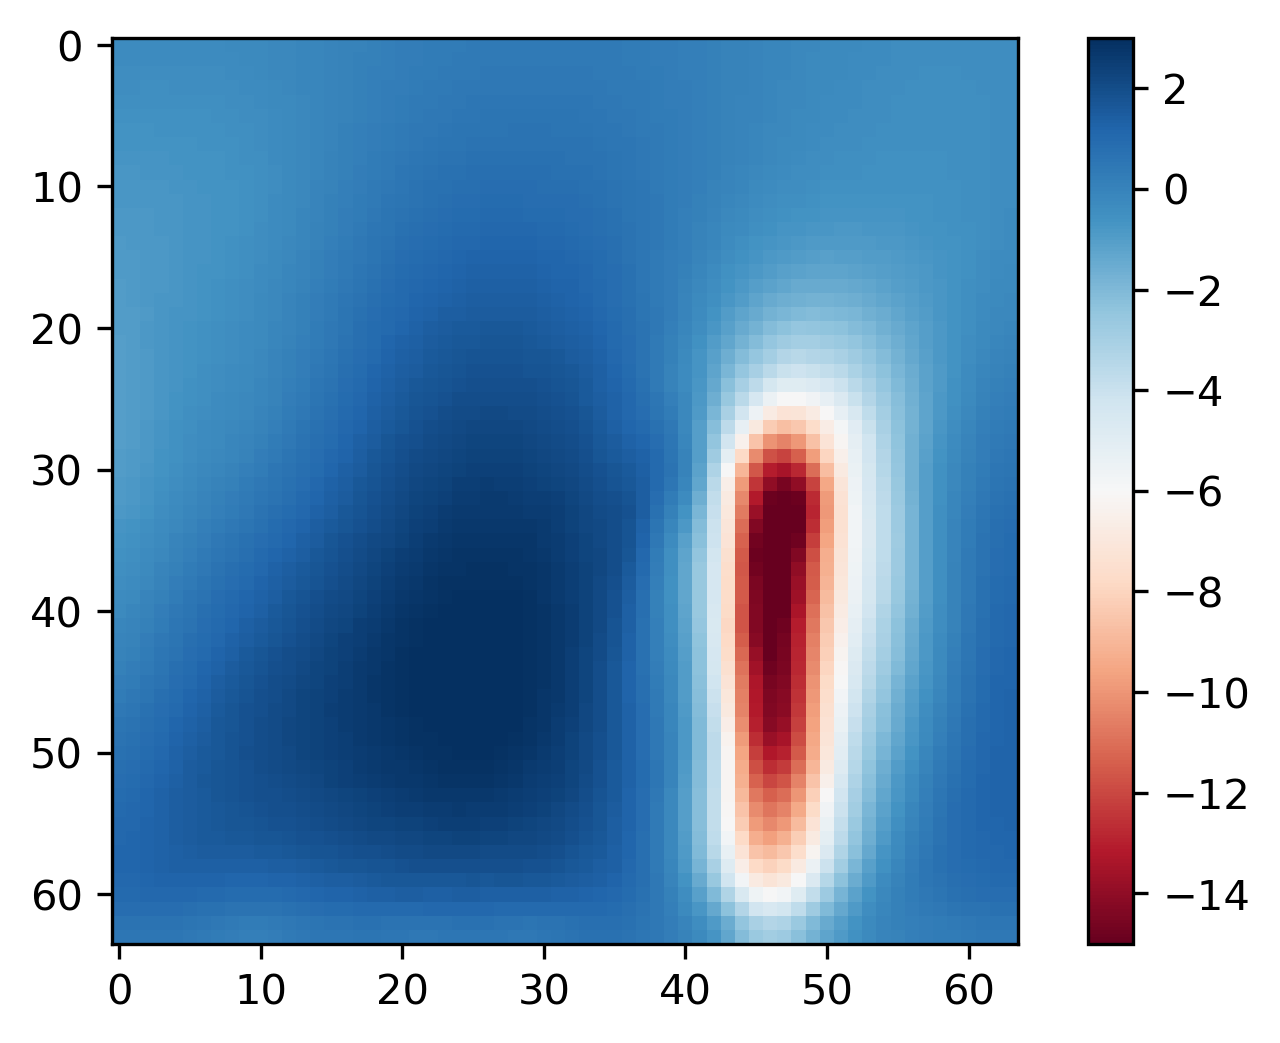

In [93]:

plt.imshow(var_[2,0,:,:],cmap="RdBu",vmin=-4,vmax=4)
plt.colorbar()
plt.figure()
plt.imshow(var_[1,0,:,:],cmap="RdBu",vmin=-15,vmax=3)
plt.colorbar()